## Phase locked windows in brain data

In [44]:
import numpy as np
import pandas as pd
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import GPMAlgorithm as GPM
import importlib
import matplotlib.pyplot as plt
import csv
import cmath
from scipy.signal import butter, lfilter, hilbert, argrelextrema
importlib.reload(KFB)
importlib.reload(GPM)

<module 'GPMAlgorithm' from '/Users/Moncho/Desktop/Year 1/kuramotocontrol/GPMAlgorithm.py'>

In [2]:
#Same fMRI pre-processing done in the other notebook

N = 66
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]
FilteredSignals =KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
analytic_signal = hilbert(FilteredSignals,axis=0)
Hilbert = np.zeros((300,N))
for i in range(0,N):
    for t in range(0,300):
        Hilbert[t,i]=m.atan2(analytic_signal[t,i].real,analytic_signal[t,i].imag)

In [45]:
# Phase locking algorithm - frob norm
window_length = 30
PLV_index = np.zeros(300-window_length)
for t0 in range(0,300-window_length):
    PLV = KFB.CalculatePhaseLockingValue(Hilbert[t0:t0+window_length,:])
    PLV_index[t0] = KFB.CalculatePhaseLockingIndex(PLV)
local_maxima = argrelextrema(PLV_index,np.greater)[0]


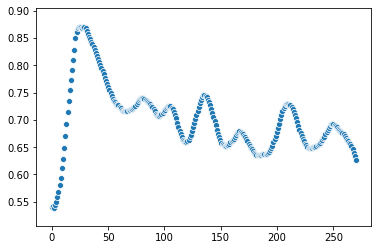

In [59]:
t = np.linspace(0,len(PLV_index),num=len(PLV_index))
sns.scatterplot(t,PLV_index)
chosen_windows =[]
for locmax in local_maxima:
    if PLV_index[locmax]>0.7:
        chosen_windows.append(locmax)
for w in chosen_windows:
    for c in chosen_windows:
        if np.abs(w-c)<window_length:
            if PLV_index[w]>PLV_index[c]:
                chosen_windows.remove(c)
            else:
                chosen_windows.remove(w)

### Now that we have extracted the chosen phase locked windows, we extract a functional pattern for each one

In [72]:
BOLDPhases = np.zeros((window_length,N,len(chosen_windows)))
BOLDPhases_no_mod = np.zeros((window_length,N,len(chosen_windows)))

for i in range(0,len(chosen_windows)):
    t0 = chosen_windows[i]
    BOLDPhases[:,:,i] = Hilbert[t0:t0+window_length,:]
    BOLDPhases_no_mod[:,:,i] = KFB.RemoveBounds(BOLDPhases[:,:,i])

#Complete identical steps to in previous cases to extract R and F matrices for these 2 phase locked states



(30, 66, 3)

In [84]:
Average_Cos_Phase_Difference = np.zeros((N,N,len(chosen_windows)))
SyntheticFC = np.zeros((N,N,len(chosen_windows)))
x_min_brain = np.zeros((N,len(chosen_windows)))
for w in range(0,len(chosen_windows)):
    Cos_Phase_Differences = np.zeros((N,N,window_length))
    Phase_Differences = np.zeros((N,N,window_length))
    for i in range(0,window_length):
        for j in range(0,N):
            for k in range(0,N):
                Cos_Phase_Differences[j][k][i] = np.cos(BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w])
                Phase_Differences[j][k][i] = BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w]
    Average_Cos_Phase_Difference[:,:,w] = np.mean(Cos_Phase_Differences,axis=2)
    Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
    C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
    EstimatedPhases = GPM.GPMAlgorithm(C)
    x_min_brain[:,w] = KFB.CalculateXMinFromPhases(EstimatedPhases)
    SyntheticFC[:,:,w] = KFB.CalculateCorrelationMatrixFromPhases(EstimatedPhases)

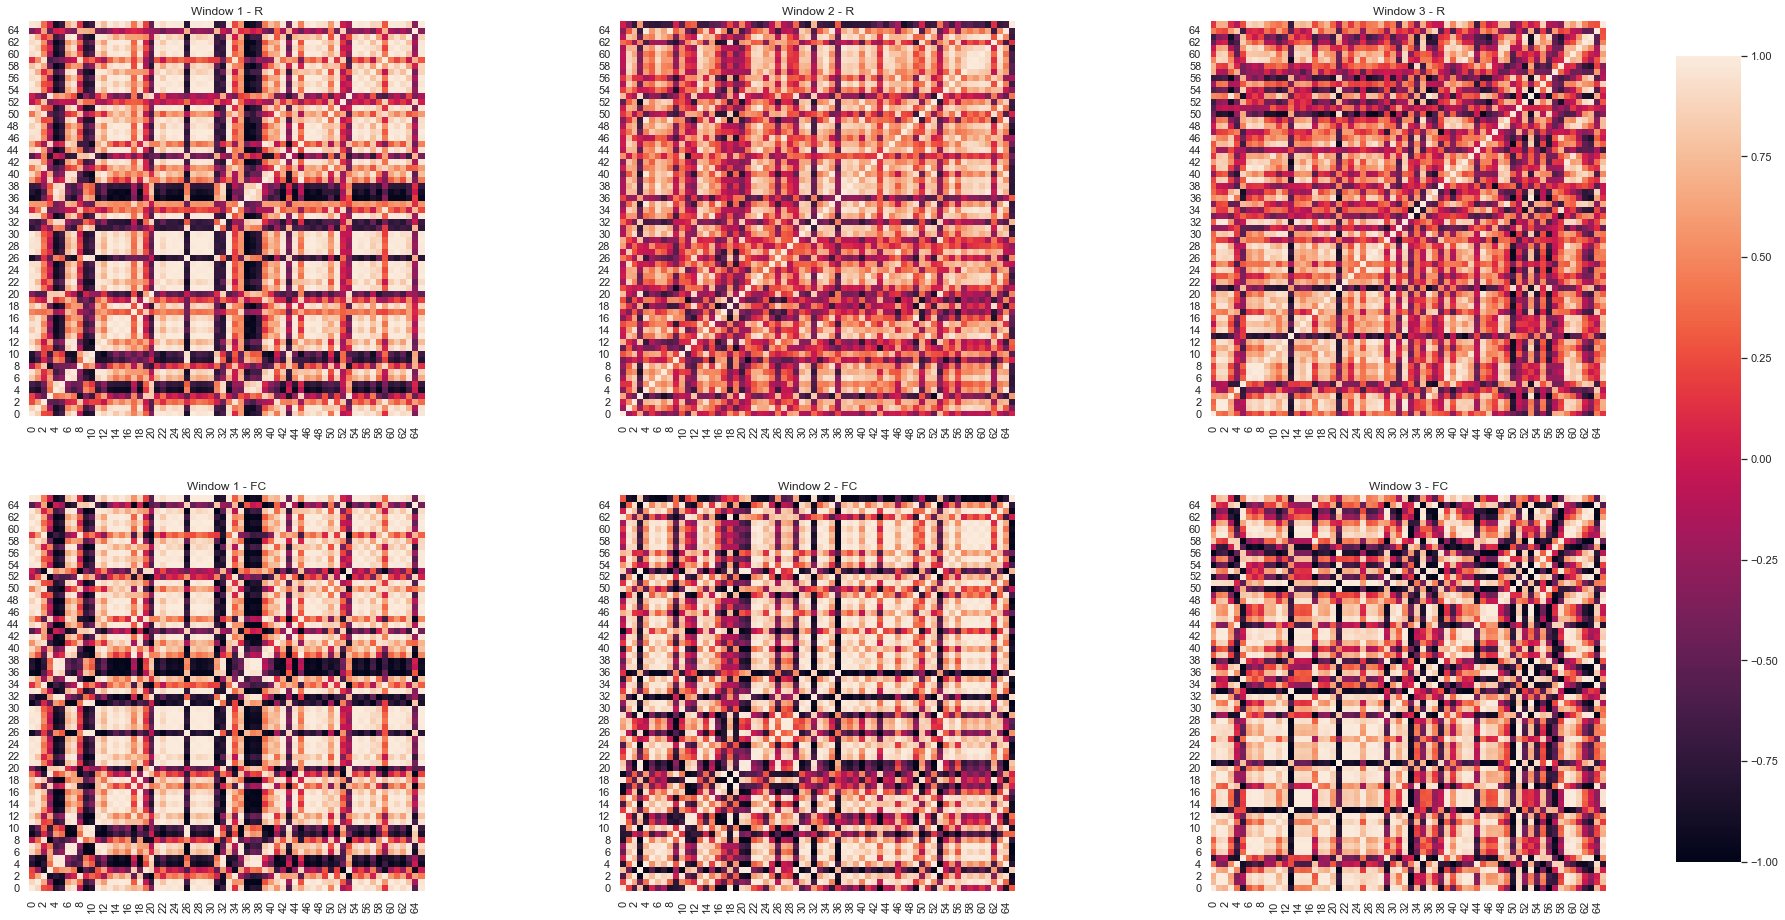

In [80]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(Average_Cos_Phase_Difference[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(Average_Cos_Phase_Difference[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(Average_Cos_Phase_Difference[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,0].title.set_text('Window 1 - R')
axs[0,1].title.set_text('Window 2 - R')
axs[0,2].title.set_text('Window 3 - R')
axs[1,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,0].title.set_text('Window 1 - FC')
axs[1,1].title.set_text('Window 2 - FC')
axs[1,2].title.set_text('Window 3 - FC')
plt.show()

### Now import structural connectivity and find a compatible frequency setting

In [103]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
#Remove Diagonals
SCMatrix = SCMatrix - np.diagflat(np.diag(SCMatrix))
SCMatrix = (SCMatrix+SCMatrix.T)/2

#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SCMatrix)
x_desired = np.zeros((len(edges),len(chosen_windows)))
D = np.zeros((len(edges),len(edges),len(chosen_windows)))
B = KFB.CalculateIncidenceMatrix(edges,N)
for w in range(0,len(chosen_windows)):
    x_desired[:,w] = KFB.CalculatePhaseDifferencesFromMin(x_min_brain[:,w],edges)
    D[:,:,w]= KFB.CalculateSinMatrix(edges,x_desired[:,w])
delta1 = KFB.CalculateDeltaFromAdj(SCMatrix,edges)

# Construct the problem and solve the convex optimisation problem
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1))
constraints = [delta_opt-delta1>=0]
for w in range(0,2):
    constraints.append(np.matmul(B,D[:,:,w])@delta_opt == w_opt)
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

In [105]:
# Construct the problem and solve the convex optimisation problem
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1)+ cp.sum_squares(np.matmul(B,D[:,:,0])@delta_opt - w_opt) + cp.sum_squares(np.matmul(B,D[:,:,1])@delta_opt - w_opt)+ cp.sum_squares(np.matmul(B,D[:,:,2])@delta_opt - w_opt))
constraints = [delta_opt-delta1>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

In [107]:
#Solving the model with these params
theta_0 = EstimatedPhases
T=40
num_points = 800

sol,t = KFB.SolveKuramotoModel(theta_0,T,N,w+0.29,SCMatrix,num_points)

#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=np.sin(sol[:,i]))

AttributeError: 'numpy.ndarray' object has no attribute 'value'